<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [2]:
import datetime
import numpy as np
import pandas as pd
from matplotlib import cm, pyplot as plt
import hmmlearn
from hmmlearn.hmm import GaussianHMM
from pandas import concat 
import matplotlib.pyplot as mp

In [3]:
fit_df = pd.read_csv("D:/PL/a_e.csv")
fit_df

,Unnamed: 0,a,b,c,d,e
0,2017-07-03,0.065553,0.008601,7.944304e-02,-0.024872,-0.001387
1,2017-07-05,0.067786,0.009242,7.888657e-02,-0.022974,-0.002364
2,2017-07-06,0.069000,0.010849,9.117983e-02,-0.008424,-0.003781
3,2017-07-07,0.064393,0.008642,7.560329e-02,-0.028884,-0.001559
4,2017-07-10,0.061552,0.008143,7.383613e-02,-0.028005,-0.001383
...,...,...,...,...,...,...
111,2017-12-08,0.073967,0.090150,1.047872e-17,-0.089406,-0.085986
112,2017-12-11,0.101133,0.220752,2.527936e-02,0.446577,-0.212609
113,2017-12-12,0.167150,0.857950,7.579108e-02,2.000000,-0.786140
114,2017-12-13,0.054356,0.124583,5.626022e-21,-0.092910,-0.121045


In [29]:
import warnings
import logging
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM
from sklearn.model_selection import train_test_split
from tqdm import tqdm

plt.style.use('ggplot')
 
class StocPredictornew(object):

    def __init__(self, data, train, test, n_hidden_states=3, n_latency_days=20, n_diff=21):
                 #n_steps_frac_change=50, n_steps_frac_high=10, n_steps_frac_low=10):
        self._init_logger()
        
        # 价格数据, rq 
        self.data = data
        self.train = train
        self.test = test
        
        # 滚动天数... 
        self.n_latency_days = n_latency_days
        self.hmm = GaussianHMM(n_components=n_hidden_states)
#         self._split_train_test_data(test_size)
        self._compute_all_possible_outcomes()
        return


    def _init_logger(self):
        self._logger = logging.getLogger(__name__)
        handler = logging.StreamHandler()
        formatter = logging.Formatter(
            '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
        handler.setFormatter(formatter)
        self._logger.addHandler(handler)
        self._logger.setLevel(logging.DEBUG)
        return
        

    def _split_train_test_data(self):
        data = self.data
        self._train_data = self.train
        self._test_data = self.test
        return
 
    @staticmethod
    def _extract_features(data):
        diff_score = np.array(data['diff'])
        last_score = np.array(data['score'])
        return np.column_stack((diff_score, last_score))
     

    def fit(self):
        #self._logger.info('>>> Extracting Features')
        feature_vector = self._extract_features(self.train)
        #self._logger.info('Features extraction Completed <<<')
        # 训练集fit
        self.hmm.fit(feature_vector)
 
    def _compute_all_possible_outcomes(self):
#         abs(diff_change_range) = np.linspace(0, 10, num=11,endpoint=True).astype(int)
        diff_change_range = list(np.linspace(-0.5, 0.5, 100))
        score_last_range = list(np.linspace(0, 0.17, 1000))
        
        self._possible_outcomes = np.array(list(itertools.product(
            diff_change_range, score_last_range)))
        return
        
    def get_most_probable_outcome(self, day_index):
        previous_data_start_index = max(0, day_index - self.n_latency_days)
        previous_data_end_index = max(0, day_index - 1)
        previous_data = self.test.iloc[previous_data_start_index: previous_data_end_index]
        previous_data_features = StocPredictornew._extract_features(
            previous_data)
        outcome_score = []
        #import pdb;pdb.set_trace()
        for possible_outcome in self._possible_outcomes:
            total_data = np.row_stack(
                (previous_data_features, possible_outcome))
            outcome_score.append(self.hmm.score(total_data))
        most_probable_outcome = self._possible_outcomes[np.argmax(
            outcome_score)]
 
        return most_probable_outcome
   
    def predict_close_price(self, day_index):
        diff_score = self.test.iloc[day_index]['diff']
        predicted_frac_change, orginal = self.get_most_probable_outcome(day_index)
        #return diff_score +  predicted_frac_change
        return orginal + predicted_frac_change
        #return open_price  + predicted_frac_change

    def predict_close_prices_for_days(self, days, with_plot=False):
        predicted_close_prices = []
        for day_index in tqdm(range(days)): # 1, 2, 3, 4, 5, 
            
            predicted_close_prices.append(self.predict_close_price(day_index))
         
        pre_dt = pd.DataFrame()
        pre_dt['predict'] = predicted_close_prices
        pre_dt['date'] = list(self.test[0: days]['date'])
        
        if with_plot:
            test_data = self.test[0: days]
            days = np.array(self.test['date'], dtype="datetime64[ms]")
            actual_close_prices = self.test['score']
            fig = plt.figure()
            axes = fig.add_subplot(111)
            axes.plot(days, actual_close_prices, 'bo-', label="actual")
            axes.plot(days, predicted_close_prices, 'r+-', label="predicted")
            #axes.set_title('{company}'.format(company=self.company))
            fig.autofmt_xdate()
 
            plt.legend()
            plt.show() 
        return pre_dt
 

In [31]:
def marcov(data, interval,days): 
    result = pd.DataFrame()
    final = data.shape[0] 
    for t in range(0, final, days): 
        start= t
        end = t+interval  #t+60
        split = end-days  #end-20
        if end <= final-days:       
            predictor = data[start:end]
            train_data = data[start:split]
            test_data = data[split:end]
#             print(len(test_data))
        elif end > final-days and end <=final:  
            predictor = data[start:]
            train_data = data[start:split]
            test_data = data[split:]
            print(start,split,end,final)
        elif end > final:
            break

            

        diff_predict = StocPredictornew(data=predictor,train=train_data,test=test_data)
        diff_predict.fit()
        part_result = diff_predict.predict_close_prices_for_days(len(test_data))
               
        result =  result.append(part_result)
        result1 = result.sort_values(by='date')
    
#     result['date'] = result.index
    print(len(result1))
    print(result1.date.duplicated().sum())
#     print(result1.head())
    print(result1)


    result1[['date', 'predict']].to_csv("C:/Users/HONGXIN/pandas file们/Project-Lab-Vol-Curve-main/marcov_%d_%d.csv" % (interval, days), index = None)
    return 

In [32]:
new = fit_df[['a']]
new['diff'] = new['a'].diff()
new['score'] = new['a']
new.dropna(inplace=True)
new.index = pd.to_datetime(new.index)
new = new.reset_index()
new.rename(columns={'index':'date'},inplace=True)

C:\Users\HONGXIN\AppData\Local\Temp\ipykernel_28216\2394571756.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new['diff'] = new['a'].diff()
C:\Users\HONGXIN\AppData\Local\Temp\ipykernel_28216\2394571756.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new['score'] = new['a']
C:\Users\HONGXIN\AppData\Local\Temp\ipykernel_28216\2394571756.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

In [33]:
new

,date,a,diff,score
0,2017-07-05,0.0678,0.0022,0.0678
1,2017-07-06,0.0690,0.0012,0.0690
2,2017-07-07,0.0644,-0.0046,0.0644
3,2017-07-10,0.0616,-0.0028,0.0616
4,2017-07-11,0.0596,-0.0020,0.0596
...,...,...,...,...
110,2017-12-08,0.0740,0.0051,0.0740
111,2017-12-11,0.1011,0.0272,0.1011
112,2017-12-12,0.1671,0.0660,0.1671
113,2017-12-13,0.0544,-0.1128,0.0544


In [34]:
new.a.max()

0.16714964408522145

In [35]:
marcov(new[['date','score','diff']],20,2)

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:57<00:00, 28.76s/it]
C:\Users\HONGXIN\AppData\Local\Temp\ipykernel_28216\1854217241.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result =  result.append(part_result)
100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:11<00:00, 35.70s/it]
C:\Users\HONGXIN\AppData\Local\Temp\ipykernel_28216\1854217241.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result =  result.append(part_result)
100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:01<00:00, 30.67s/it]
C:\Users\HONGXIN\AppData\Local\Temp\ipykernel_28216\1854217241.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:26<00:00, 43.04s/it]
C:\Users\HONGXIN\AppData\Local\Temp\ipykernel_28216\1854217241.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result =  result.append(part_result)
100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [36:32<00:00, 1096.16s/it]
C:\Users\HONGXIN\AppData\Local\Temp\ipykernel_28216\1854217241.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result =  result.append(part_result)
100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:18<00:00, 39.31s/it]
C:\Users\HONGXIN\AppData\Local\Temp\ipykernel_28216\1854217241.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:19<00:00, 39.86s/it]
C:\Users\HONGXIN\AppData\Local\Temp\ipykernel_28216\1854217241.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result =  result.append(part_result)


94 112 114 115


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:59<00:00, 39.76s/it]

97
0
    predict       date
0    0.0610 2017-07-31
1    0.0610 2017-08-01
0    0.0601 2017-08-02
1    0.0601 2017-08-03
0    0.0593 2017-08-04
..      ...        ...
0    0.0843 2017-12-08
1    0.0843 2017-12-11
0    0.0980 2017-12-12
1    0.0980 2017-12-13
2    0.0851 2017-12-14

[97 rows x 2 columns]



C:\Users\HONGXIN\AppData\Local\Temp\ipykernel_28216\1854217241.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result =  result.append(part_result)


In [36]:
predict = pd.read_csv("C:/Users/HONGXIN/pandas file们/Project-Lab-Vol-Curve-main/marcov_20_2.csv")
predict

,date,predict
0,2017-07-31,0.0610
1,2017-08-01,0.0610
2,2017-08-02,0.0601
3,2017-08-03,0.0601
4,2017-08-04,0.0593
...,...,...
92,2017-12-08,0.0843
93,2017-12-11,0.0843
94,2017-12-12,0.0980
95,2017-12-13,0.0980


In [38]:
new.shape

(115, 4)

In [39]:
a_compare = concat([predict,new[['a','diff']]],axis=1)
a_compare

,date,predict,a,diff
0,2017-07-31,0.0610,0.0678,0.0022
1,2017-08-01,0.0610,0.0690,0.0012
2,2017-08-02,0.0601,0.0644,-0.0046
3,2017-08-03,0.0601,0.0616,-0.0028
4,2017-08-04,0.0593,0.0596,-0.0020
...,...,...,...,...
110,NaN,NaN,0.0740,0.0051
111,NaN,NaN,0.1011,0.0272
112,NaN,NaN,0.1671,0.0660
113,NaN,NaN,0.0544,-0.1128


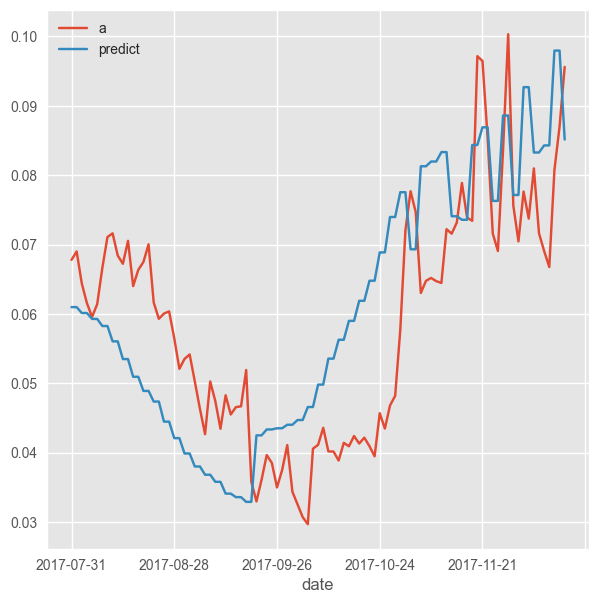

In [40]:
a_compare.dropna().plot(x="date", y=["a", "predict"],
        kind="line", figsize=(7,7))
mp.show()